In [21]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [22]:
chicago = pd.read_csv("prediction_data.csv", parse_dates=["start_time"])
chicago.head(1)

,start_time,month,day,hour,mean_duration,max_temp,precip,trips,isWeekday
0,2016-01-01,1.0,1.0,0.0,13.2,-4.4,0.0,25,0


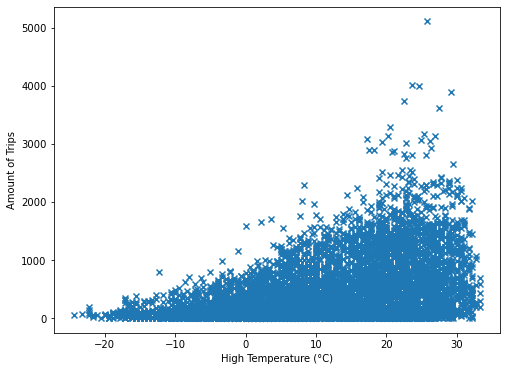

In [25]:
Xp = chicago["max_temp"].values
Yp = chicago["trips"].values
plt.figure(figsize = (8,6))
plt.scatter(Xp, Yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Amount of Trips")
plt.show()

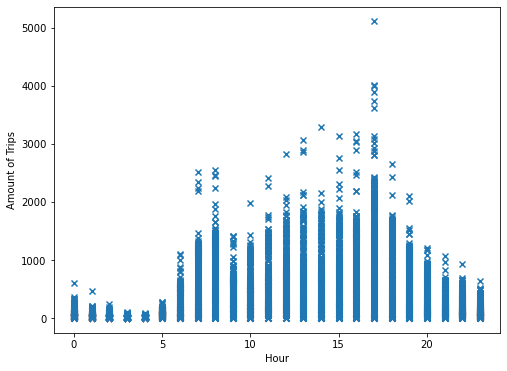

In [26]:
Xp = chicago["hour"]
Yp = chicago["trips"].values
plt.figure(figsize = (8,6))
plt.scatter(Xp, Yp, marker="x")
plt.xlabel("Hour")
plt.ylabel("Amount of Trips")
plt.show()

In [27]:
#Xp = feature_data[["month","day","hour","max_temp","precip","isWeekday"]]
Yp = chicago["trips"].values
#scaler = StandardScaler()
#Xp_sc = scaler.fit_transform(Xp)
Xp = chicago["max_temp"].values.reshape([-1,1])

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def plot_tree_regression_line(tree_depth):

    # Fit regression model (to full data)
    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,criterion="mse")
    Tree_reg.fit(Xp , Yp) 
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(Xp, Yp, marker="x")
    plt.plot(np.arange(-25,35,1), Tree_reg.predict(np.arange(-25,35,1).reshape((-1,1))), marker="x", color='C1')
    plt.xlabel("High Temperature (°C)", fontsize=16)
    plt.ylabel("Peak Demand (GW)", fontsize=16)
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    
    #plt.savefig("Peak_Power_Regression_Lines_{}depth.pdf".format(tree_depth))

number of nodes:  31
number of leafs:  16


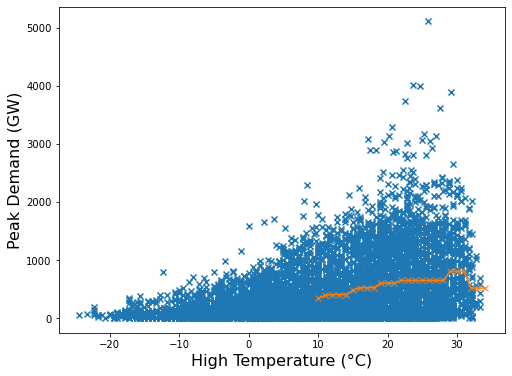

In [29]:
plot_tree_regression_line(4)

In [30]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

def plot_regression_tree_sklearn(tree_depth):

    # Fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(Xp, Yp) 
    
    dot_data = export_graphviz(model,
                              feature_names=["High_temp"])  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

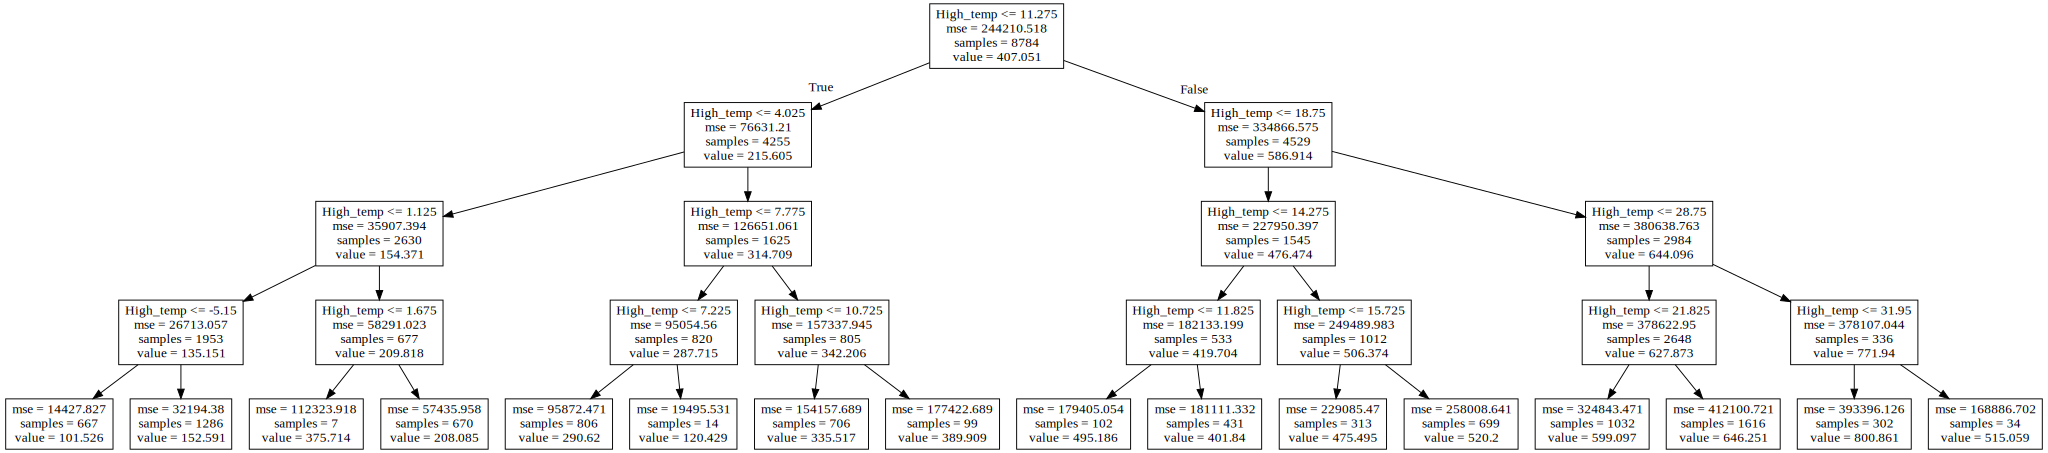

In [31]:
plot_regression_tree_sklearn(4)

In [38]:
Xp = chicago[["month","hour","max_temp","precip","isWeekday"]]
Yp = chicago["trips"].values
scaler = StandardScaler()
Xp_sc = scaler.fit_transform(Xp)

In [39]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

def plot_regression_tree_sklearn(tree_depth):

    # Fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(Xp, Yp) 
    
    dot_data = export_graphviz(model,
                              feature_names=["month","hour","max_temp","precip","isWeekday"])  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

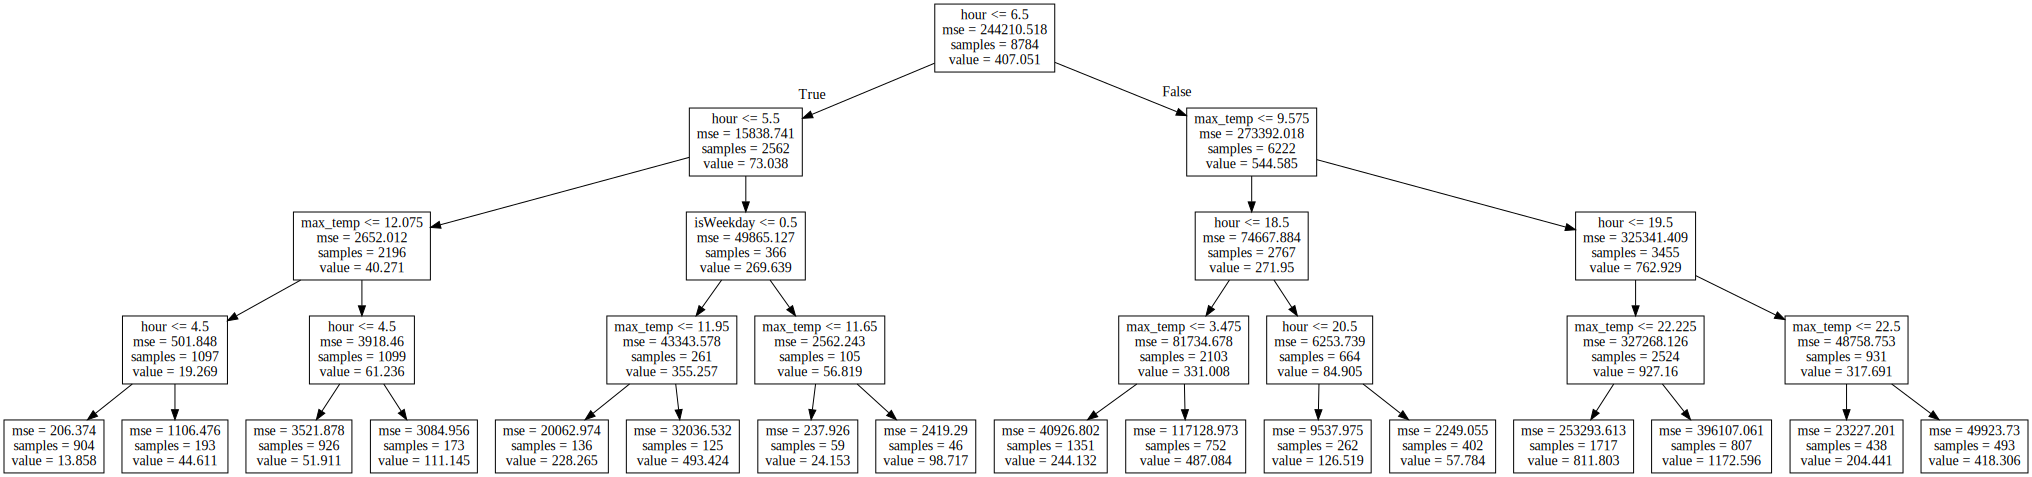

In [40]:
plot_regression_tree_sklearn(4)

In [41]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# train test split
X_train, X_test, y_train, y_test = train_test_split(Xp, Yp, random_state=0)
# fit decision tree (without limit on max_depth, i.e. tree will grow fully if alpha is set to 0)
tree_classifier = DecisionTreeClassifier(random_state=0, criterion="gini")
# compute cost_complexity_pruning_path 
path = tree_classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

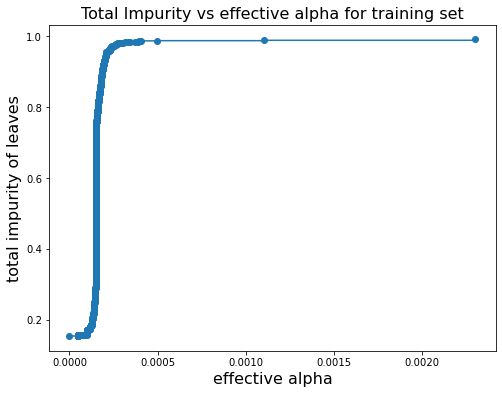

In [42]:
#plot cost_complexity_pruning_path

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")  # we remove the last alpha as this corresponds to a tree with only the root node
ax.set_xlabel("effective alpha",fontsize=16)
ax.set_ylabel("total impurity of leaves",fontsize=16)
ax.set_title("Total Impurity vs effective alpha for training set",fontsize=16)

plt.savefig("Determining_Alpha.pdf")

In [43]:
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      trees[-1].tree_.node_count, ccp_alphas[-1]))

KeyboardInterrupt: 

In [ ]:
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha",fontsize=16)
ax[0].set_ylabel("number of nodes",fontsize=16)
ax[0].set_title("Number of nodes vs alpha",fontsize=16)
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha",fontsize=16)
ax[1].set_ylabel("depth of tree",fontsize=16)
ax[1].set_title("Depth vs alpha",fontsize=16)
fig.tight_layout()


In [ ]:
len(ccp_alphas)

In [ ]:
scores_train = []
scores_val = []

# run loop

for ccp_alpha in ccp_alphas:
    
    model = DecisionTreeClassifier(random_state=0,ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)    
    
    from sklearn.metrics import accuracy_score
    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracy_val = accuracy_score(y_test, model.predict(X_test))
    scores_val.append(accuracy_val)
    scores_train.append(accuracy_train)

# collect results in DF
df = pd.DataFrame(columns=["alpha","train_score","valid_score"])
df["alpha"]=ccp_alphas
df["train_score"] = scores_train
df["valid_score"] = scores_val

# show top five alphas
df.sort_values("valid_score",ascending=False).head(5)

In [ ]:
plt.subplots(figsize=(8,6))
plt.plot(df["alpha"],df["train_score"], marker='o')
plt.plot(df["alpha"],df["valid_score"], marker='o')
plt.legend(["train","validation"])
plt.xlabel("effective alpha",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.title("Accuracy for different alpha",fontsize=16)
#plt.savefig("alpha_tuning.pdf")
plt.show()